# Unsupervised Anomaly Detection in Time Series
Author: Antons Ruberts

In [2]:
#Utility
import pandas as pd
import numpy as np
from datetime import datetime

#Anomaly Detection ADTK
from adtk.detector import PersistAD
from adtk.detector import SeasonalAD
from adtk.detector import AutoregressionAD

#Anomaly Detection ML
from sklearn.neighbors import LocalOutlierFactor

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
from adtk.visualization import plot
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams["figure.figsize"] = (20,10)

## Data

Data is taken from this Kaggle competition: https://www.kaggle.com/c/web-traffic-time-series-forecasting

In [4]:
df = pd.read_csv('./data/wiki_ts.csv')

In [5]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


We can see that the data is represented as: each row is a website, and each column is a day.

In [7]:
print(f'There is {df.shape[0]} websites, with visitis between {df.columns[1]} and {df.columns[-1]}')

There is 145063 websites, with visitis between 2015-07-01 and 2016-12-31


We can also see that there are missing values in some of the websites. Let's filter out the timeseries where we have missing values, because we don't really need them to show the anomaly detection algorithms.

In [23]:
no_nas = df.loc[(df.isna().sum(axis=1) == 0), :]

In [24]:
no_nas.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


Now, let's plot a random website traffic to see how the data looks like

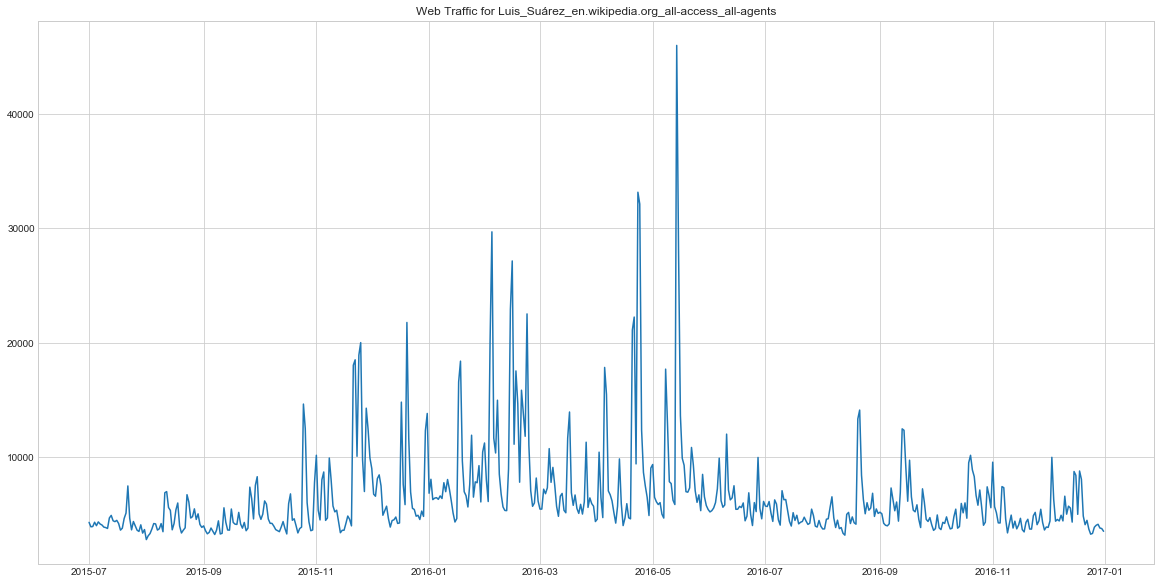

In [78]:
wiki_sample = no_nas.sample(random_state=42).iloc[:, 1:]
x = pd.to_datetime(wiki_sample.columns.ravel())
y = wiki_sample.values.ravel()

plt.title(f'Web Traffic for {no_nas.sample(random_state=42).iloc[:, 0].values[0]}')
sns.lineplot(x, y)

This timeseries representes the traffic on the Luis Suarez wikipage (he's footabl player for Barcelona). It has quite a few spikes, which might be explained by the footbal season activity and his performance in the matches. For example, detecting these spikes might be useful in forecasting demand for his merchendise. Let's take a look at another timeseries for future analysis.

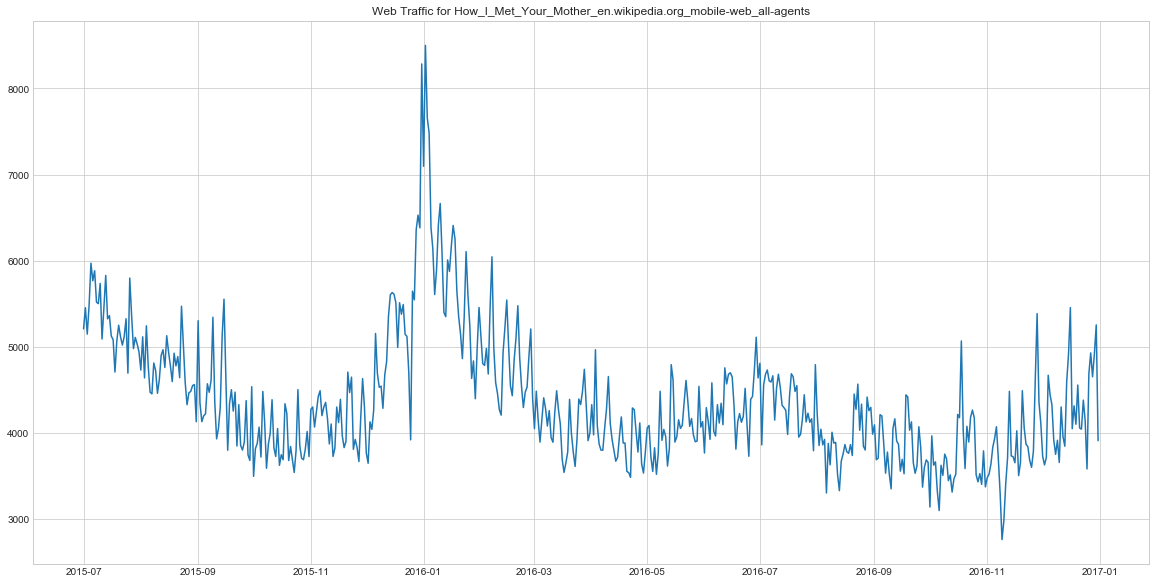

In [79]:
wiki_sample = no_nas.sample(random_state=33333).iloc[:, 1:]
x2 = pd.to_datetime(wiki_sample.columns.ravel())
y2 = wiki_sample.values.ravel()

plt.title(f'Web Traffic for {no_nas.sample(random_state=33333).iloc[:, 0].values[0]}')
sns.lineplot(x2, y2)

This time series is for a TV-show How I Met Your Mother. We can see that it has some sort of a seasonal pattern which might be connected to the broadcasting scheduel. Understadning the anomalies here might be useful in evaluating the success of different episode.

## Anomaly Detection with ADTK: Rolling Average, Auto-regressive, and Seasonal Models

These three methods are the first approaches to try when working with time-series. Rolling average (denoted as `persistAD` in `adtk` package) is the simplest of these approaches but it can work surprisingly well when the data is not very complicated. When the Rolling Average approach fails, Auto-Regressive and Seasonal approaches may performa better because most of the time-series are indeed generated by the auto-regressive processes, and some of them have a seasonal component.
* **Rolling Average** approach compares the current value with the average of preceeding period. If the change in rolling averages is too large, this point is considered as anomaly. 
* **Auto-regressive** model builds a regression model in the background with lagged values of a time-series. The points which cannot be accurately predicted by the AR model are considered as outliers. 
* **Seasonal model** decomposes the time-series into the trend, seasonal, and residual components. If residual component is abnormally large, we can say that this point is an outlier. 

In [69]:
s1 = pd.Series(data=y, index=x)
s2 = pd.Series(data=y2, index=x2)

### Rolling Average

In [169]:
persist_ad = PersistAD(window=7, c=3, side='both')

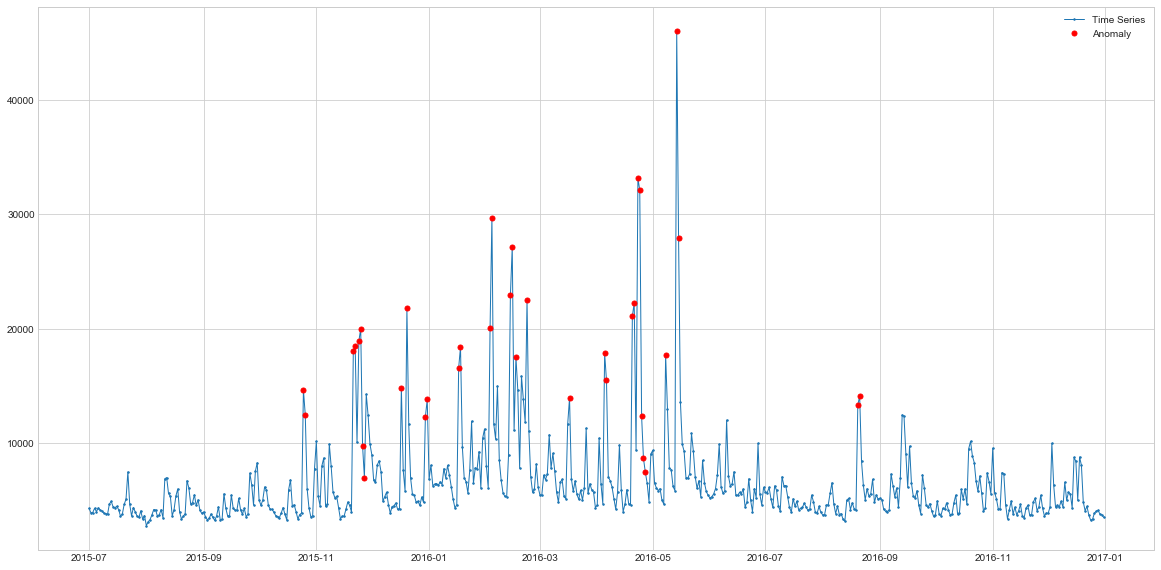

In [165]:
anomalies1 = persist_ad.fit_detect(s1)
plot(s1, anomaly=anomalies1, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Here I'm using 7 day rolling averages to find the outliers. We can see that the highlighted points are indeed spikes in the time-series and could be considered as outliers. Hence, the simplest approach already does a pretty good job at finding the anomalies. Let's see how it performs with seasonal data.

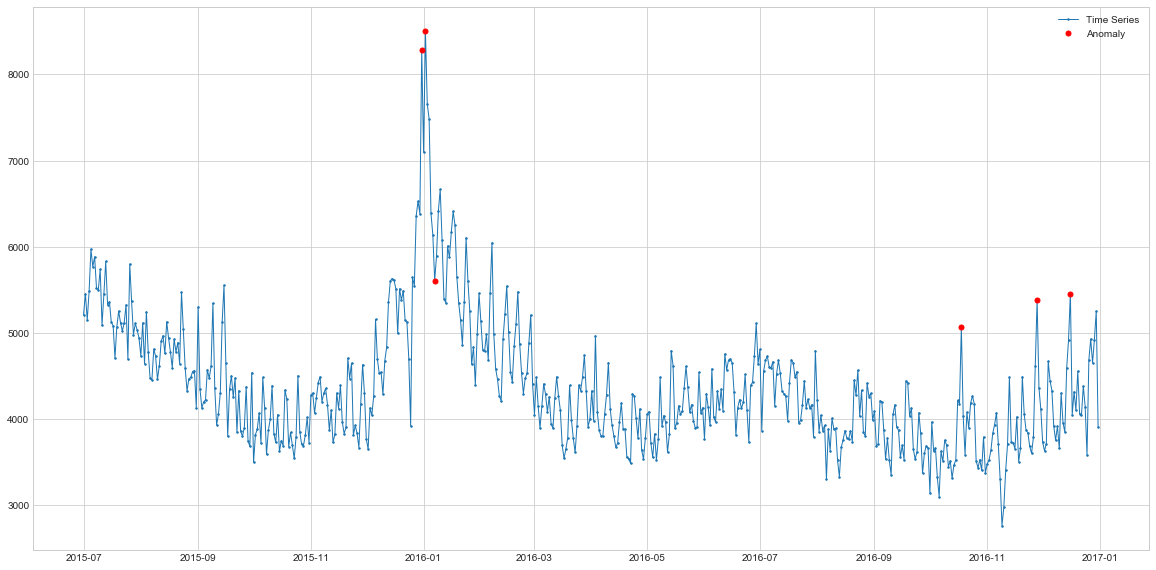

In [179]:
anomalies2 = persist_ad.fit_detect(s2)
plot(s2, anomaly=anomalies2, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Here, the model also picks up the main outlier spikes (christmas and new year) and it also highlights some of the spikes closer to the end of time-series. You will need some business context to understand whether these are indeed outliers or they were mislabeled. But overall, the Moving Average approach does a decent job at this dataset.

### Seasonal

In [110]:
seasonal_ad = SeasonalAD(c=3.0, side="both")

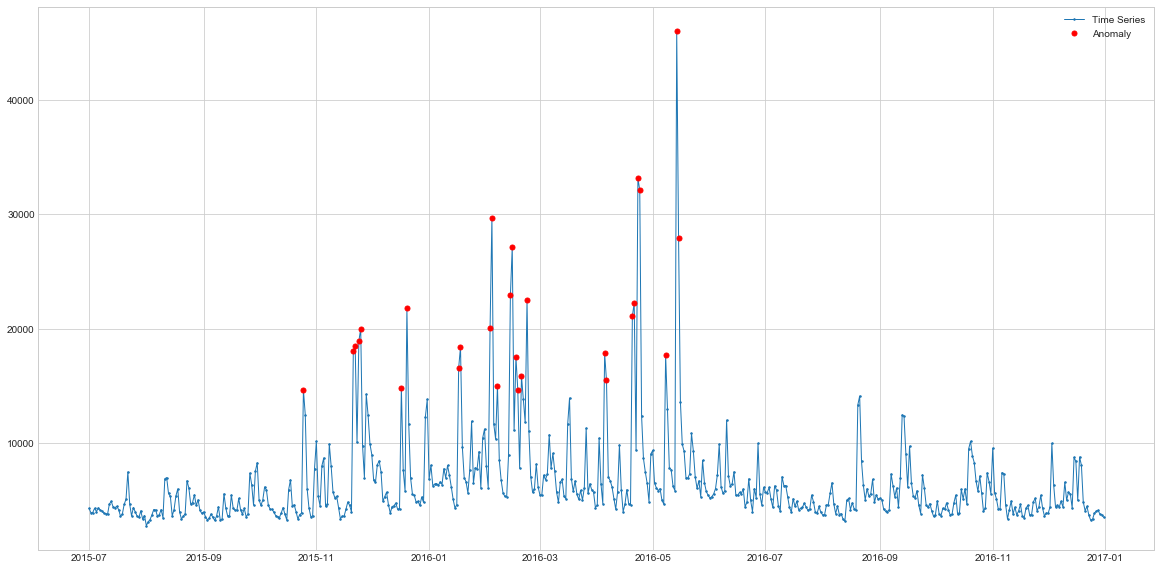

In [111]:
anomalies_season1 = seasonal_ad.fit_detect(s1)
plot(s1, anomaly=anomalies_season1, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Comparing to Rolling Averages approach, Seasonal model is a lot more consistent in the outliers it identifies. These are the spikes which do not match seasonal pattern. That's why we can see some of the spikes not highilghted - these are seasonal spikes and not outliers. In this sense, the model highlights less points, but these points are more likely to be outliers.

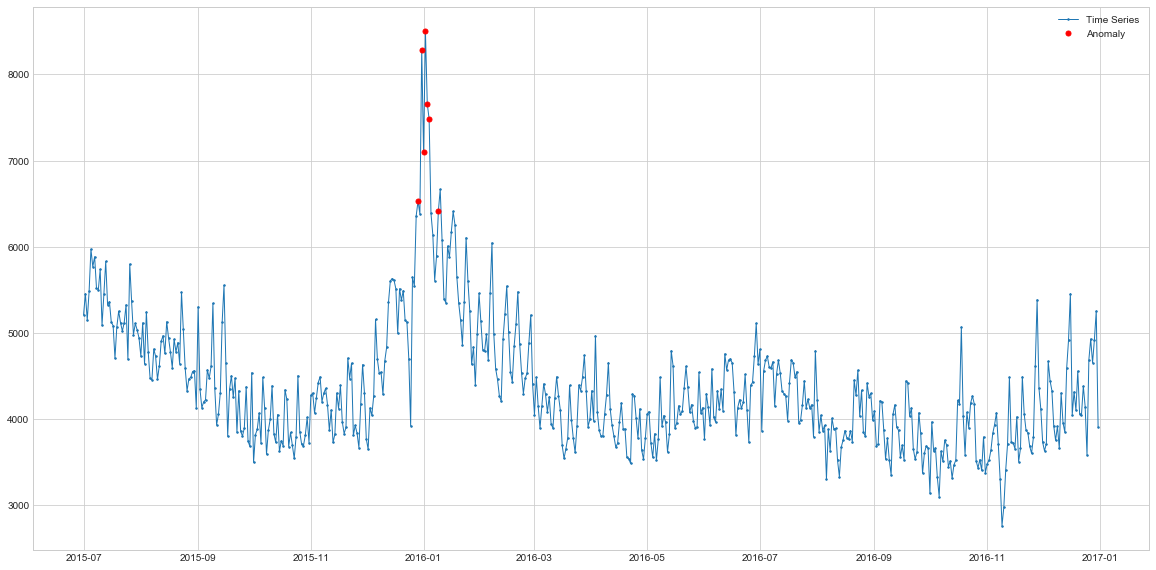

In [112]:
anomalies_season2 = seasonal_ad.fit_detect(s2)
plot(s2, anomaly=anomalies_season2, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Here again, the key outliers are highlighted meaning that the spike during the Christmas period of 2015 is abnormal. But the seasonal model doesn't highlight the December 2016 spikes, meaning that these spikes are in-line with seasonal expectation of a model. If we look closely at the time series, we can see that indeed during the December period wee can expect larger number of visits. Hence, the Seasonal model again is more likely to be correct than simple Moving Averages. 

### Auto-Regressive

To determine how many lags do we need to include, let's check the autocorrelation of both of these time series.

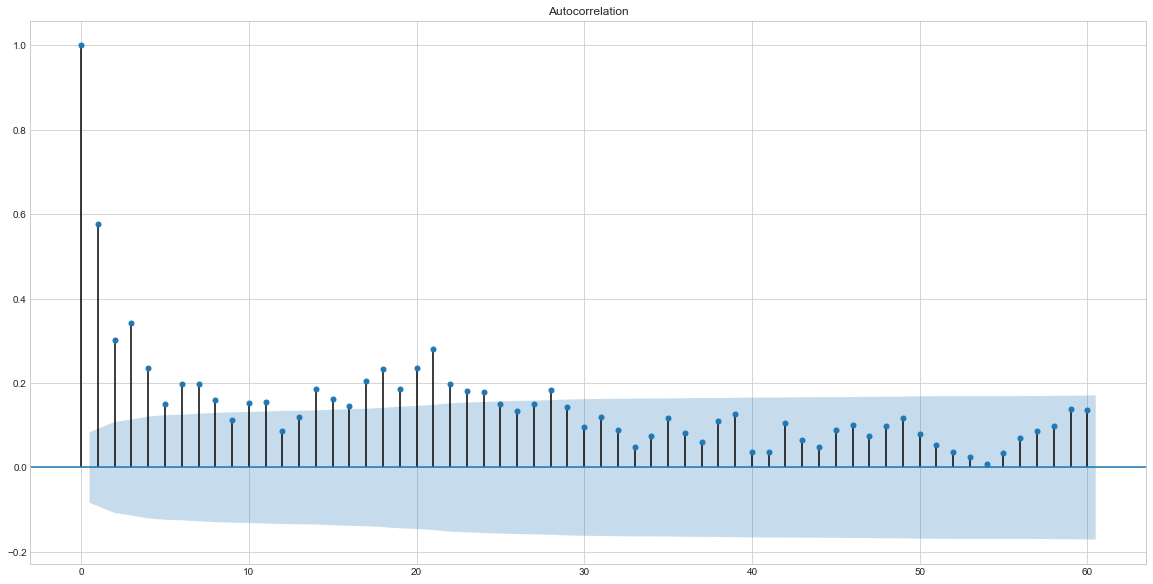

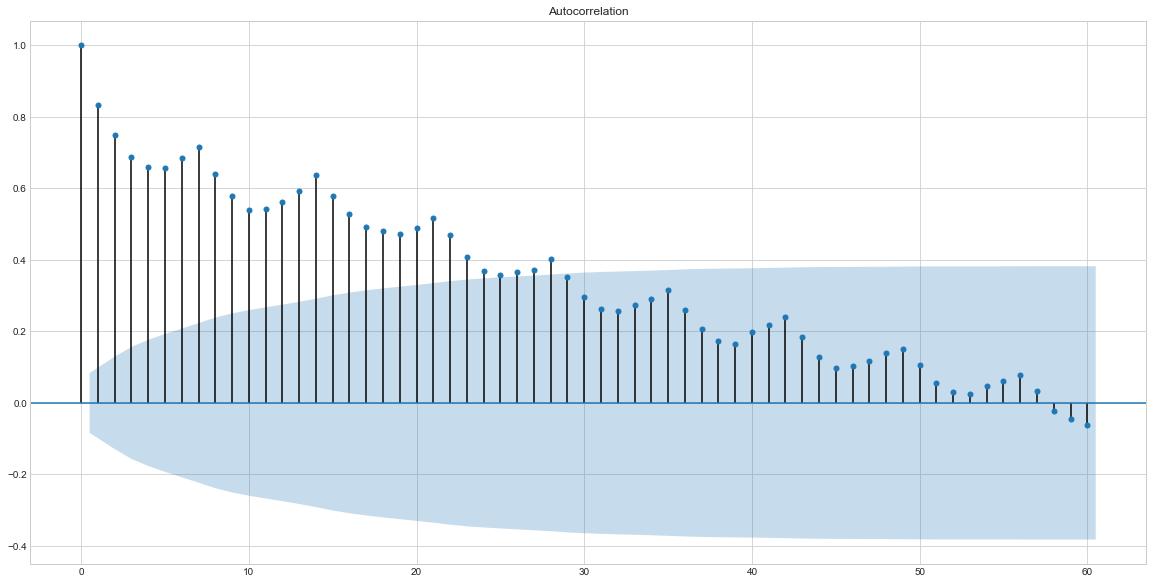

In [196]:
acf = plot_acf(s1, lags = 60)
acf = plot_acf(s2, lags = 60)

Looks like including 30 time steps will be enough to capture the time-dependence of this time-series.

In [197]:
autoregression_ad = AutoregressionAD(n_steps=30, step_size=1, c=3.0)

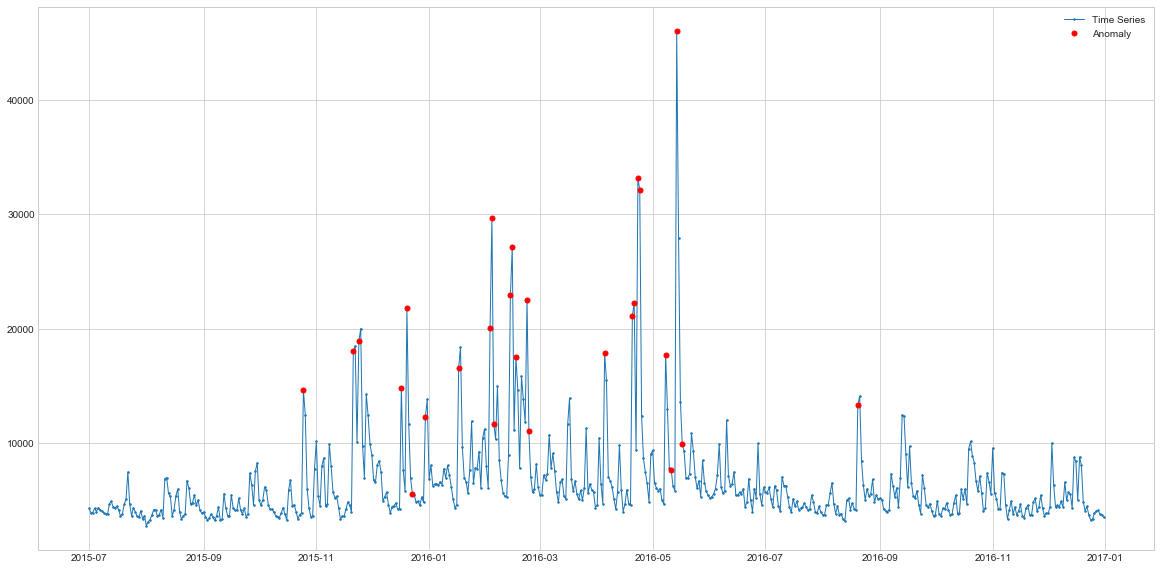

In [198]:
anomalies_ar1 = autoregression_ad.fit_detect(s1.resample('D').sum())
plot(s1, anomaly=anomalies_ar1, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

The AR model is able to capture spikes and performs quite similarly to the Rolling-Average approach. 

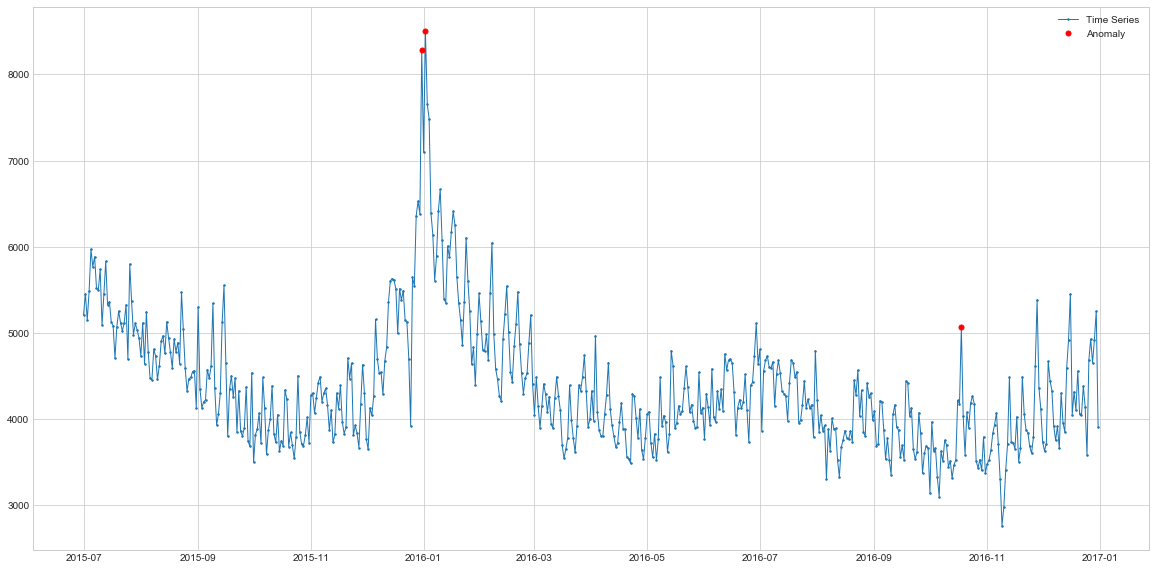

In [199]:
anomalies_ar2 = autoregression_ad.fit_detect(s2.resample('D').sum())
plot(s2, anomaly=anomalies_ar2, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

On this dataset, AR finds two areas of anomaly, similar to the Rolling Average. However, while the Rollign Average has identified multiple points closer to the end of the series, AR only finds the most important one - the one where the shift happens. Again, there is no saying which model is the most correct without a labeled dataset. 

## Anomaly Detection with ML: Density Based and Isolation Forest

### Density Based: HDBSCAN

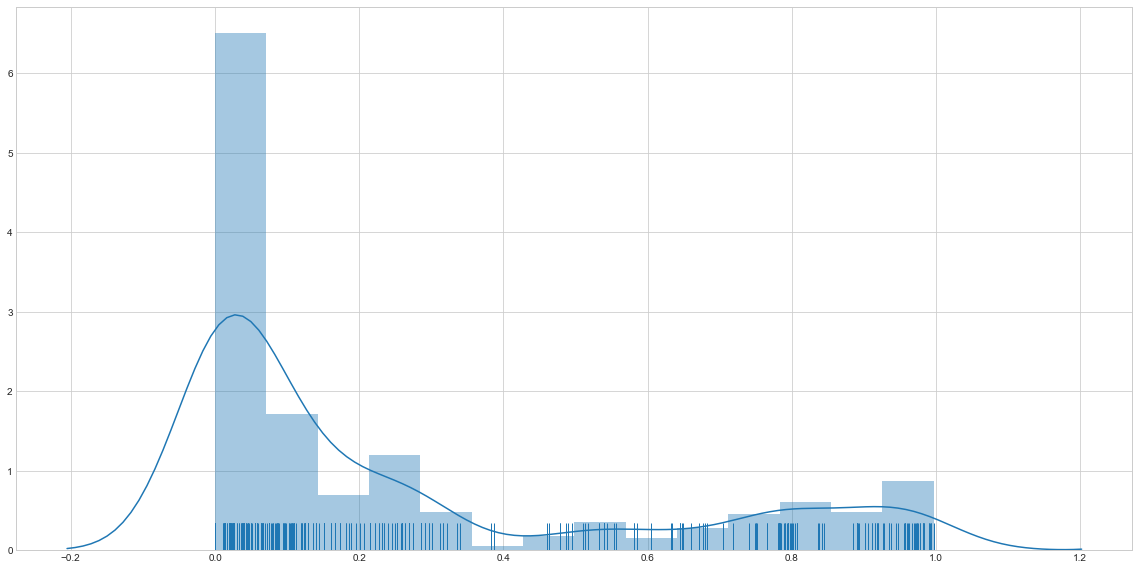

In [227]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(np.array(s1).reshape(-1,1))
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

In the distribution of outlier scores we can already see that the right outlier tail is quite significant. Let's plot the outliers which belong to the top 10% according to this score.

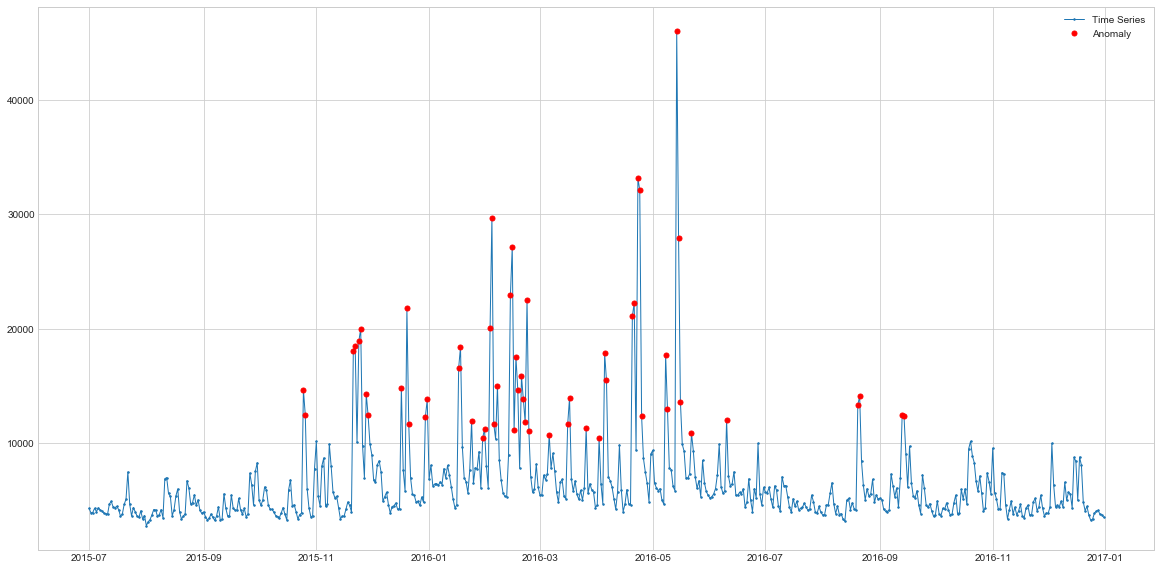

In [228]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
outliers = s1[outliers]
outliers_series = pd.Series(s1.index.isin(outliers.index), index=s1.index)
plot(s1, anomaly=outliers_series, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Overall, the HDBSCAN does a pretty good job at detecting the spikes and it's also moe consistent as it detects mostly the spikes and not the falls after the spikes. Let's see how it performs on the seasonal dataset.

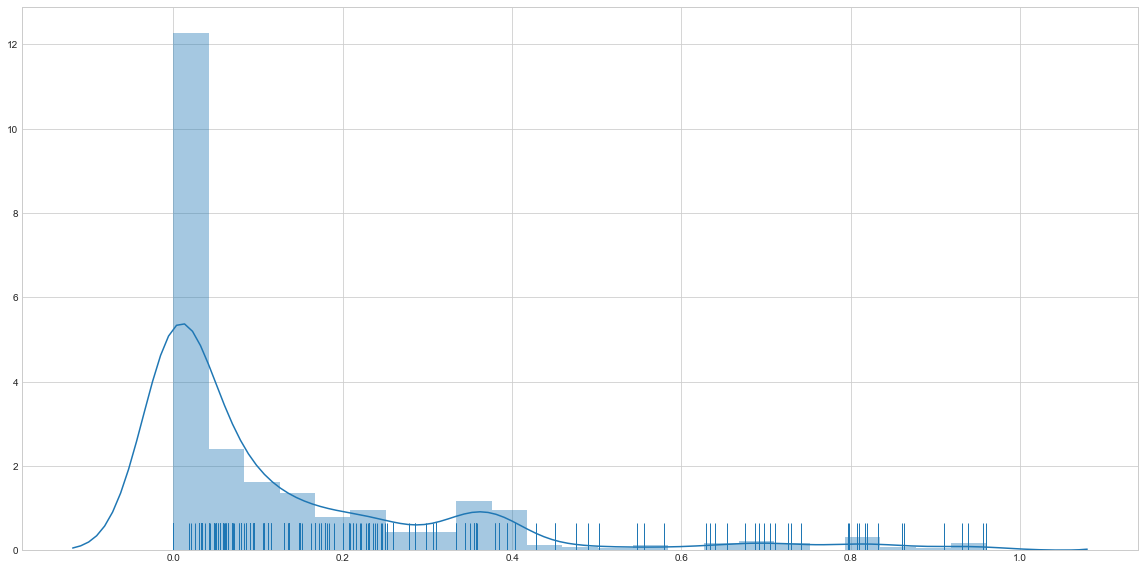

In [229]:
clusterer2 = hdbscan.HDBSCAN(min_cluster_size=15).fit(np.array(s2).reshape(-1,1))
sns.distplot(clusterer2.outlier_scores_[np.isfinite(clusterer2.outlier_scores_)], rug=True)

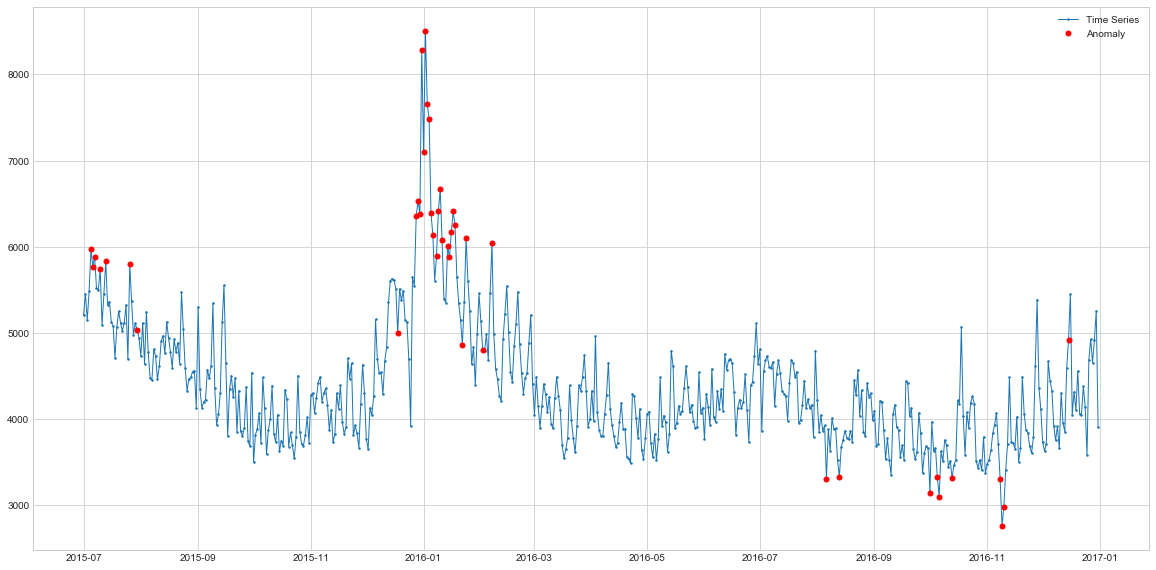

In [238]:
threshold2 = pd.Series(clusterer2.outlier_scores_).quantile(0.90)
outliers2 = np.where(clusterer2.outlier_scores_ > threshold2)[0]
outliers2 = s2[outliers2]
outliers_series2 = pd.Series(s2.index.isin(outliers2.index), index=s2.index)
plot(s2, anomaly=outliers_series2, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Interstingly, on this dataset, HDBSCAN is the first algorithm to detect also the downturns. On the other hand, it also seems to mislabel some points at the beginning of the series, so it might be an indiciation that we need to increase the quantile from 90% to e.g. 95% or 98%. 

### Density Based: LOF

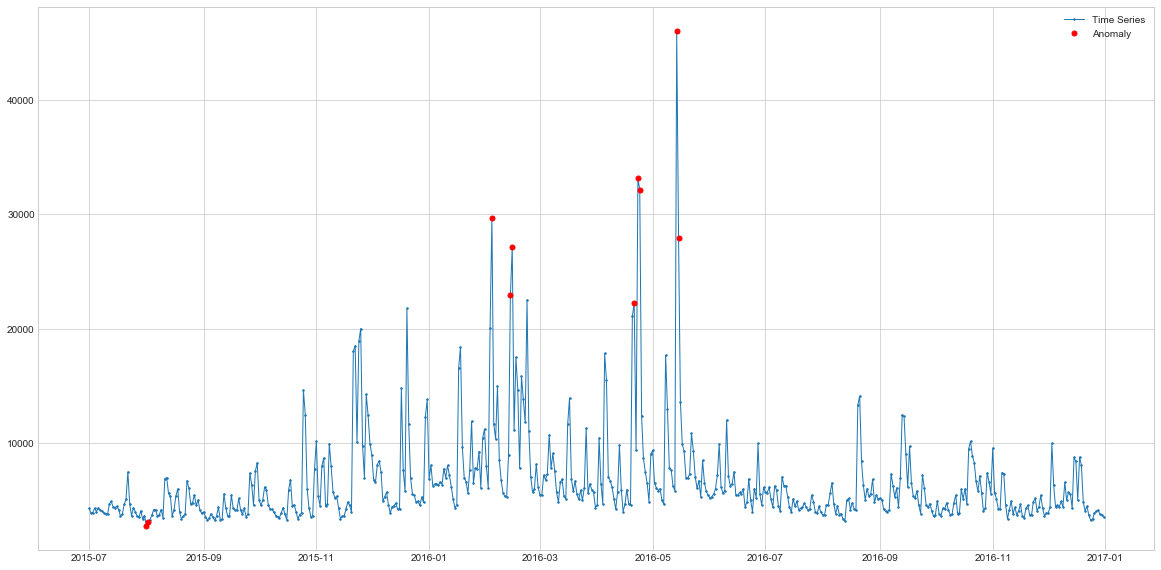

In [303]:
clf = LocalOutlierFactor(contamination='auto')
lof_outliers1 = clf.fit_predict(np.array(s1).reshape(-1,1))
lof_outliers1 = pd.Series([x == -1 for x in lof_outliers1], index=s1.index)
plot(s1, anomaly=lof_outliers1, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

With default parameters, the LOF algorithm fails to find some of the spikes and it also misclassifies two low points as outliers. Overall, this algortihm seems to not be suitable for this type of of series. Let's see how it does at the seasonal data.

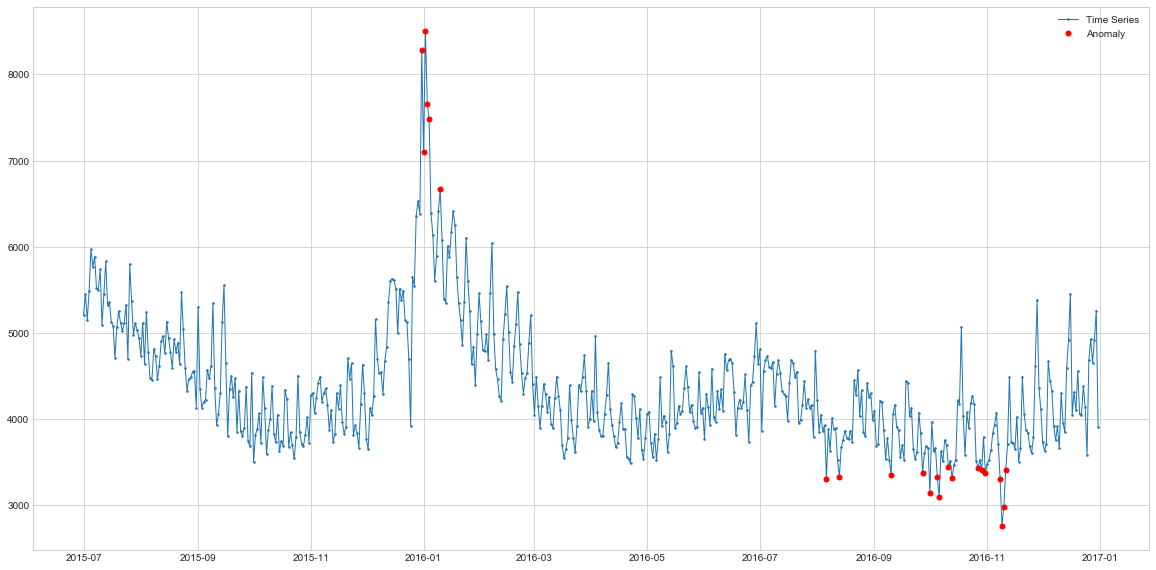

In [304]:
lof_outliers2 = clf.fit_predict(np.array(s2).reshape(-1,1))
lof_outliers2 = pd.Series([x == -1 for x in lof_outliers2], index=s2.index)
plot(s2, anomaly=lof_outliers2, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Here the performance is better, as it finds the main outlier peak and it also detects the lower points at the end of the series. Because these points are indeed lower than anything we have seen in the series, they might be considered as anomalies or, at least, they should be detected. 

### Isolation Forest

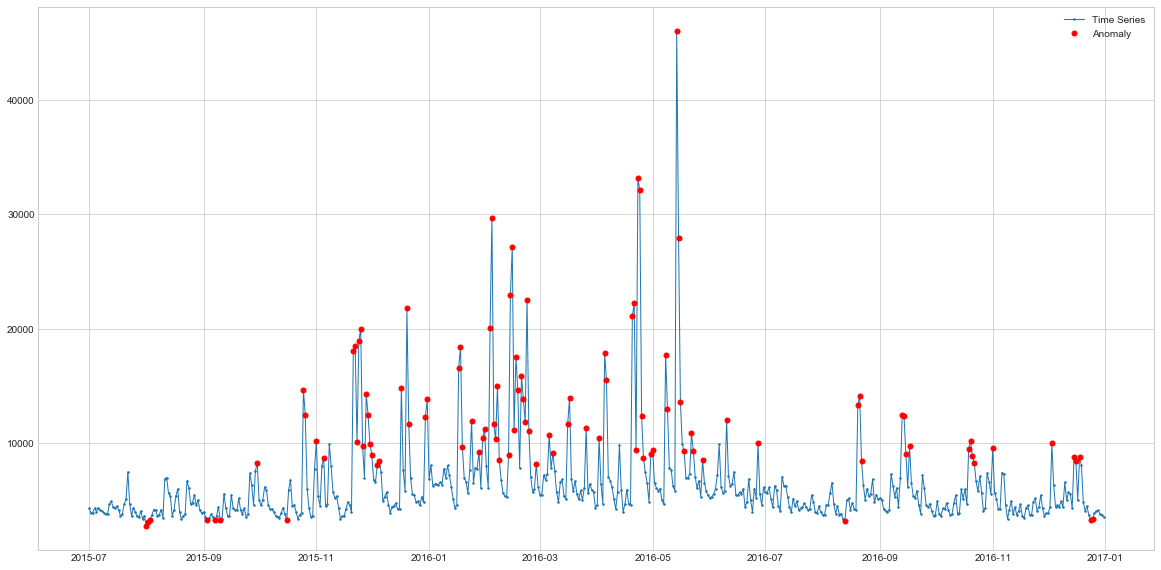

In [305]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination='auto', behaviour="new")
if_outliers1 = clf.fit_predict(np.array(s1).reshape(-1,1))
if_outliers1 = pd.Series([x == -1 for x in if_outliers1], index=s1.index)
plot(s1, anomaly=if_outliers1, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

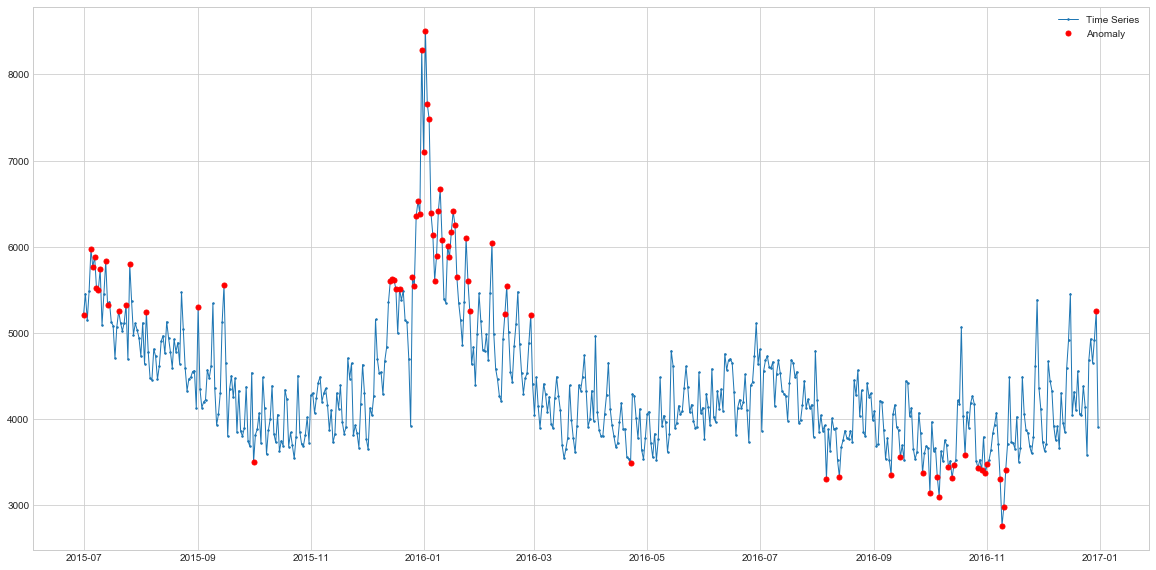

In [306]:
if_outliers2 = clf.fit_predict(np.array(s2).reshape(-1,1))
if_outliers2 = pd.Series([x == -1 for x in if_outliers2], index=s2.index)
plot(s2, anomaly=if_outliers2, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

It seems like the Isolation Forest with default parameters consider too many points as outliers. Changing the contamination proportion should help, but we won't really know this value in production. Hence, this is a key limitation of this algorithm and it may not be suited to find the outliers in these series.

# Evaluation on Labeled Dataset

In [308]:
train = pd.read_csv('./data/phase2_train.csv')

First, let's select a single time-series to demonstrate how the data looks like

In [ ]:
kpi = 'c69a50cf-ee03-3bd7-831e-407d36c7ee91'
kpi_train = train.loc[train['KPI ID'] == kpi, :]
kpi_train.timestamp = kpi_train.timestamp.apply(lambda x: datetime.fromtimestamp(x))
kpi_train.index = kpi_train.timestamp

In [348]:
#Proportion of anomalies
kpi_train['label'].value_counts(normalize=True)

0    0.993997
1    0.006003
Name: label, dtype: float64

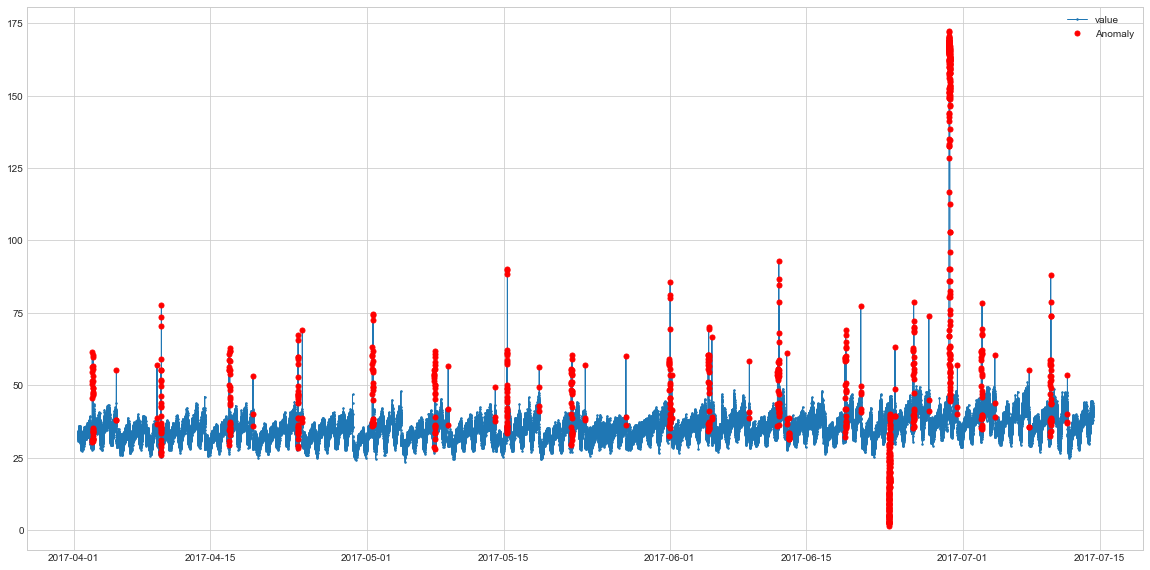

In [350]:
plot(kpi_train.value, anomaly=kpi_train['label'], ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

In [532]:
class SeriesAnomalyDetector:
    def rolling_avg(self, data, window):
        persist_ad = PersistAD(window=window, c=3, side='both') #Compares 2 hours means
        persist_anomalies = persist_ad.fit_detect(data)
        return persist_anomalies.fillna(0)
    
    def ar(self, data, n_steps, step_size):
        autoregression_ad = AutoregressionAD(n_steps=n_steps, step_size=step_size, c=3.0)
        ar_anomalies = autoregression_ad.fit_detect(data)
        return ar_anomalies.fillna(0)
    
    def seasonal(self, data):
        seasonal_ad = SeasonalAD(c=3.0, side="both")
        season_anomalies = seasonal_ad.fit_detect(data)
        season_anomalies = season_anomalies[data.index]
        return season_anomalies.fillna(0)
    
    def hdbscan(self, data, q):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(np.array(data).reshape(-1,1))
        threshold = pd.Series(clusterer.outlier_scores_).quantile(q)
        hdbscan_outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
        hdbscan_outliers = data[hdbscan_outliers]
        hdbscan_anomalies = pd.Series(data.index.isin(hdbscan_outliers.index), index=data.index)
        return hdbscan_anomalies.fillna(0)
    
    def lof(self, data, c):
        clf = LocalOutlierFactor(contamination=c)
        lof_outliers = clf.fit_predict(np.array(data).reshape(-1,1))
        lof_anomalies = pd.Series([x == -1 for x in lof_outliers], index=data.index)
        return lof_anomalies.fillna(0)
    
    def isolation_f(self, data, c):
        clf = IsolationForest(contamination=c, behaviour="new")
        if_outliers = clf.fit_predict(np.array(data).reshape(-1,1))
        if_anomalies = pd.Series([x == -1 for x in if_outliers], index=data.index)
        return if_anomalies.fillna(0)

In [537]:
pd.infer_freq(kpi_train.index) == None

True

In [540]:
#Find contamination
c = kpi_train['label'].value_counts(normalize=True)[1]
q = 1-c
if pd.infer_freq(kpi_train.index) == None:
    freq = '1T'
else:
    freq = pd.infer_freq(kpi_train.index)
    
data = kpi_train.value.resample(freq).sum()


detector = SeriesAnomalyDetector()
ra = detector.rolling_avg(data, 60)
ar = detector.ar(data, 60, 1)
seasonal = detector.seasonal(data)
hdb = detector.hdbscan(data, q)
lof = detector.lof(data, c)
isolation_f = detector.isolation_f(data, c)

C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


In [548]:
from sklearn.metrics import f1_score

anomalies = [ra, ar, seasonal, hdb, lof, isolation_f]
methods = ['Rolling Average', 'Auto-Regressive', 'Seasonal Model', 'HDBSCAN', 'LOF', 'Isolation Forest']

for i, a in enumerate(anomalies):

    print(f'{methods[i]} F1 score: {f1_score(kpi_train.label.values,a[kpi_train.label.index])}')

Rolling Average F1 score: 0.45981452859350846
Auto-Regressive F1 score: 0.3463203463203463
Seasonal Model F1 score: 0.7220670391061453
HDBSCAN F1 score: 0.478082992402104
LOF F1 score: 0.06989853438556932
Isolation Forest F1 score: 0.566068515497553


Now, let's see the performance on all the other series that we have

In [585]:
from tqdm import tqdm
#Saving the proportion for later testing
contamination_dict = {}
performance = {}

for kpi in tqdm(train['KPI ID'].unique()):
    #Data Selection
    filt_df = train.loc[train['KPI ID'] == kpi, :]
    filt_df.timestamp = filt_df.timestamp.apply(lambda x: datetime.fromtimestamp(x))
    filt_df.index = filt_df.timestamp
    filt_df = filt_df.sort_index()
    filt_df = filt_df.loc[~filt_df.index.duplicated(keep='first')]
    c = filt_df['label'].value_counts(normalize=True)[1]
    q = 1-c
    data = filt_df.value.resample(pd.infer_freq(filt_df.index[:5])).sum()
    
    #Anomaly detection
    detector = SeriesAnomalyDetector()
    ra = detector.rolling_avg(data, 60)
    ar = detector.ar(data, 60, 1)
    try:
        seasonal = detector.seasonal(data)
    except:
        seasonal = pd.Series(index=data.index).fillna(False)
    hdb = detector.hdbscan(data, q)
    lof = detector.lof(data, c)
    isolation_f = detector.isolation_f(data, c)
    f1_scores = []
    anomalies = [ra, ar, seasonal, hdb, lof, isolation_f]
    methods = ['Rolling Average', 'Auto-Regressive', 'Seasonal Model', 'HDBSCAN', 'LOF', 'Isolation Forest']
    for i, a in enumerate(anomalies):
        f1_scores.append(f1_score(filt_df.label.values, a[filt_df.label.index]))
        print(f'{methods[i]} F1 score: {f1_score(filt_df.label.values, a[filt_df.label.index])}')
    
    #Storing parameters and results
    contamination_dict[kpi] = c
    performance[kpi] = f1_scores








  0%|                                                                                           | 0/29 [00:00<?, ?it/s]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.06998987284798021
Auto-Regressive F1 score: 0.08078671883261075
Seasonal Model F1 score: 0.1408609420779806
HDBSCAN F1 score: 0.09038317566187981
LOF F1 score: 0.08817526194040005
Isolation Forest F1 score: 0.04248655273371009









  3%|██▊                                                                                | 1/29 [00:33<15:29, 33.18s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Rolling Average F1 score: 0.04166666666666667
Auto-Regressive F1 score: 0.2631578947368421
Seasonal Model F1 score: 0.04210526315789474
HDBSCAN F1 score: 0.04000000000000001
LOF F1 score: 0.04000000000000001
Isolation Forest F1 score: 0.03468208092485548









  7%|█████▋                                                                             | 2/29 [00:35<10:49, 24.07s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
C:\Users\anton\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
 

Rolling Average F1 score: 0.0
Auto-Regressive F1 score: 0.11444921316165949
Seasonal Model F1 score: 0.0
HDBSCAN F1 score: 0.010638297872340425
LOF F1 score: 0.13227513227513227
Isolation Forest F1 score: 0.37665782493368705









 10%|████████▌                                                                          | 3/29 [00:37<07:32, 17.40s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.3287671232876712
Auto-Regressive F1 score: 0.15668202764976957


C:\Users\anton\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Seasonal Model F1 score: 0.0
HDBSCAN F1 score: 0.384
LOF F1 score: 0.08
Isolation Forest F1 score: 0.384









 14%|███████████▍                                                                       | 4/29 [00:40<05:26, 13.07s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.34853420195439744
Auto-Regressive F1 score: 0.20454545454545453
Seasonal Model F1 score: 0.5138632162661737
HDBSCAN F1 score: 0.12280701754385963
LOF F1 score: 0.08844507845934381
Isolation Forest F1 score: 0.6219686162624821









 17%|██████████████▎                                                                    | 5/29 [00:44<04:03, 10.13s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Rolling Average F1 score: 0.14285714285714288
Auto-Regressive F1 score: 0.21052631578947367
Seasonal Model F1 score: 0.14285714285714288
HDBSCAN F1 score: 0.15384615384615385
LOF F1 score: 0.15384615384615385
Isolation Forest F1 score: 0.15384615384615385









 21%|█████████████████▏                                                                 | 6/29 [00:47<03:08,  8.20s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Rolling Average F1 score: 0.0
Auto-Regressive F1 score: 0.18181818181818182
Seasonal Model F1 score: 0.2857142857142857
HDBSCAN F1 score: 0.3333333333333333
LOF F1 score: 0.3333333333333333
Isolation Forest F1 score: 0.3333333333333333









 24%|████████████████████                                                               | 7/29 [00:51<02:28,  6.74s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Rolling Average F1 score: 0.0
Auto-Regressive F1 score: 0.4411764705882353
Seasonal Model F1 score: 0.0
HDBSCAN F1 score: 0.017543859649122806
LOF F1 score: 0.02631578947368421
Isolation Forest F1 score: 0.00881057268722467









 28%|██████████████████████▉                                                            | 8/29 [00:54<02:00,  5.73s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.012649130372286906
Auto-Regressive F1 score: 0.01569952305246423


C:\Users\anton\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Seasonal Model F1 score: 0.0
HDBSCAN F1 score: 0.32407407407407407
LOF F1 score: 0.0
Isolation Forest F1 score: 0.3333333333333333









 31%|█████████████████████████▍                                                        | 9/29 [06:44<36:22, 109.11s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.06832074793239842
Auto-Regressive F1 score: 0.041360060898249174
Seasonal Model F1 score: 0.15880522713130055
HDBSCAN F1 score: 0.06340718105423987
LOF F1 score: 0.14357535367707236
Isolation Forest F1 score: 0.26010336355163943









 34%|████████████████████████████▎                                                     | 10/29 [07:28<28:17, 89.35s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.03581176984386941
Auto-Regressive F1 score: 0.05755555555555555
Seasonal Model F1 score: 0.02285253394273424
HDBSCAN F1 score: 0.03535142658315935
LOF F1 score: 0.062128222075346996
Isolation Forest F1 score: 0.24921658986175116









 38%|███████████████████████████████                                                   | 11/29 [08:15<23:03, 76.84s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.02809278350515464
Auto-Regressive F1 score: 0.029976836081209973
Seasonal Model F1 score: 0.009581881533101045
HDBSCAN F1 score: 0.027027027027027032
LOF F1 score: 0.04702738810955243
Isolation Forest F1 score: 0.2850260315486829









 41%|█████████████████████████████████▉                                                | 12/29 [08:57<18:50, 66.47s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.1061836352279825
Auto-Regressive F1 score: 0.013435833506475517


C:\Users\anton\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Seasonal Model F1 score: 0.0
HDBSCAN F1 score: 0.36792452830188677
LOF F1 score: 0.0
Isolation Forest F1 score: 0.7766990291262137









 45%|████████████████████████████████████▎                                            | 13/29 [14:49<40:34, 152.14s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.09546482561599809
Auto-Regressive F1 score: 0.0725258121380005


C:\Users\anton\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Seasonal Model F1 score: 0.0
HDBSCAN F1 score: 0.06136027599802858
LOF F1 score: 0.1074911807428927
Isolation Forest F1 score: 0.41098120467663163









 48%|███████████████████████████████████████                                          | 14/29 [15:30<29:39, 118.66s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.2444359171143515
Auto-Regressive F1 score: 0.22810087493566647
Seasonal Model F1 score: 0.5927954137075383
HDBSCAN F1 score: 0.02661955241460542
LOF F1 score: 0.04723878078956248
Isolation Forest F1 score: 0.13660504201680673









 52%|██████████████████████████████████████████▍                                       | 15/29 [16:13<22:24, 96.00s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.4947330185252452
Auto-Regressive F1 score: 0.33938236230499846
Seasonal Model F1 score: 0.6604708798017348
HDBSCAN F1 score: 0.42931937172774876
LOF F1 score: 0.09944237918215613
Isolation Forest F1 score: 0.3780487804878049









 55%|█████████████████████████████████████████████▏                                    | 16/29 [17:00<17:37, 81.36s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.45981452859350846
Auto-Regressive F1 score: 0.3463203463203463
Seasonal Model F1 score: 0.7220670391061453
HDBSCAN F1 score: 0.478082992402104
LOF F1 score: 0.06989853438556932
Isolation Forest F1 score: 0.5838011226944667









 59%|████████████████████████████████████████████████                                  | 17/29 [17:46<14:06, 70.52s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.49558061566595546
Auto-Regressive F1 score: 0.3726578764746703
Seasonal Model F1 score: 0.5128755364806867
HDBSCAN F1 score: 0.31886625332152346
LOF F1 score: 0.08628659476117102
Isolation Forest F1 score: 0.3155149934810952









 62%|██████████████████████████████████████████████████▉                               | 18/29 [18:32<11:35, 63.27s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.46083251392985897
Auto-Regressive F1 score: 0.34240116068190063
Seasonal Model F1 score: 0.4236343366778149
HDBSCAN F1 score: 0.25617977528089886
LOF F1 score: 0.09616232906925451
Isolation Forest F1 score: 0.24421965317919075









 66%|█████████████████████████████████████████████████████▋                            | 19/29 [19:18<09:41, 58.16s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.2667178110216085
Auto-Regressive F1 score: 0.23470774807430908
Seasonal Model F1 score: 0.4952178533475027
HDBSCAN F1 score: 0.31609092536244854
LOF F1 score: 0.07226771092915629
Isolation Forest F1 score: 0.4973660308810172









 69%|████████████████████████████████████████████████████████▌                         | 20/29 [20:05<08:12, 54.73s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.3629764065335753
Auto-Regressive F1 score: 0.19879197015455674
Seasonal Model F1 score: 0.9057501904036557
HDBSCAN F1 score: 0.22829931972789116
LOF F1 score: 0.19913130638155696
Isolation Forest F1 score: 0.3043381037567084









 72%|███████████████████████████████████████████████████████████▍                      | 21/29 [20:34<06:17, 47.15s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.3460306944904493
Auto-Regressive F1 score: 0.19244451973572763
Seasonal Model F1 score: 0.875169483865136
HDBSCAN F1 score: 0.23760523854069227
LOF F1 score: 0.2261327713382508
Isolation Forest F1 score: 0.3167042889390519









 76%|██████████████████████████████████████████████████████████████▏                   | 22/29 [21:05<04:54, 42.05s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.45126612517916864
Auto-Regressive F1 score: 0.32469857944371494
Seasonal Model F1 score: 0.6073710073710074
HDBSCAN F1 score: 0.21140819964349378
LOF F1 score: 0.017467248908296942
Isolation Forest F1 score: 0.4065244667503137









 79%|█████████████████████████████████████████████████████████████████                 | 23/29 [21:38<03:56, 39.45s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.18192746944500102
Auto-Regressive F1 score: 0.1292134831460674
Seasonal Model F1 score: 0.032357473035439135
HDBSCAN F1 score: 0.017467248908296942
LOF F1 score: 0.018777467039552537


C:\Users\anton\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Isolation Forest F1 score: 0.0









 83%|███████████████████████████████████████████████████████████████████▊              | 24/29 [22:31<03:37, 43.57s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.18058832782759163
Auto-Regressive F1 score: 0.11187739463601533
Seasonal Model F1 score: 0.029918864097363083
HDBSCAN F1 score: 0.04432292416174989
LOF F1 score: 0.022199798183652877
Isolation Forest F1 score: 0.034705228031145716









 86%|██████████████████████████████████████████████████████████████████████▋           | 25/29 [23:23<03:04, 46.06s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.12734864300626303
Auto-Regressive F1 score: 0.10817031070195628
Seasonal Model F1 score: 0.10026385224274406
HDBSCAN F1 score: 0.04236006051437216
LOF F1 score: 0.0


C:\Users\anton\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Isolation Forest F1 score: 0.0









 90%|█████████████████████████████████████████████████████████████████████████▌        | 26/29 [24:11<02:19, 46.63s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.13059360730593608
Auto-Regressive F1 score: 0.107429718875502
Seasonal Model F1 score: 0.07612456747404844
HDBSCAN F1 score: 0.032225579053373615
LOF F1 score: 0.003587443946188341
Isolation Forest F1 score: 0.04797979797979798









 93%|████████████████████████████████████████████████████████████████████████████▎     | 27/29 [25:00<01:34, 47.36s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.4658227848101266
Auto-Regressive F1 score: 0.41043239533287573
Seasonal Model F1 score: 0.7260579064587973
HDBSCAN F1 score: 0.40662894098625707
LOF F1 score: 0.14894354000692758
Isolation Forest F1 score: 0.6249398170438132









 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [25:48<00:47, 47.61s/it]C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\anton\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


Rolling Average F1 score: 0.445859872611465
Auto-Regressive F1 score: 0.39024390243902435
Seasonal Model F1 score: 0.7190605239385727
HDBSCAN F1 score: 0.4508432743726862
LOF F1 score: 0.1546572934973638
Isolation Forest F1 score: 0.6089965397923875









100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [26:35<00:00, 55.00s/it]


In [594]:
#Average Performance
performance_df = pd.DataFrame(performance).transpose()
performance_df.columns = methods
performance_df.describe()

,Rolling Average,Auto-Regressive,Seasonal Model,HDBSCAN,LOF,Isolation Forest
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.220444,0.197261,0.303303,0.190621,0.088442,0.302444
std,0.178242,0.128727,0.313945,0.159429,0.076753,0.214451
min,0.000000,0.013436,0.000000,0.010638,0.000000,0.000000
25%,0.068321,0.107430,0.022853,0.040000,0.026316,0.136605
50%,0.180588,0.192445,0.142857,0.153846,0.080000,0.315515
75%,0.362976,0.324699,0.592795,0.324074,0.132275,0.406524
max,0.495581,0.441176,0.905750,0.478083,0.333333,0.776699


Now this table is interesting because if we look at the averages, Seasonal Model and Isolation Forest perform the best. However, Seasonal model's standard deviation is quite large and so if we look at the median values, Isolation forest is a clear winner, followed by Auto Regressibve and Rolling averages models. This indicates that when the seasonal model is applicable, it has the best performance but, unfortunately, not all the cases have seasonal patterns so it can fail miserably sometimes. Let's see the cases where both algorithms perform the best.

### Isolation Forest Exploration

C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Ground Truth


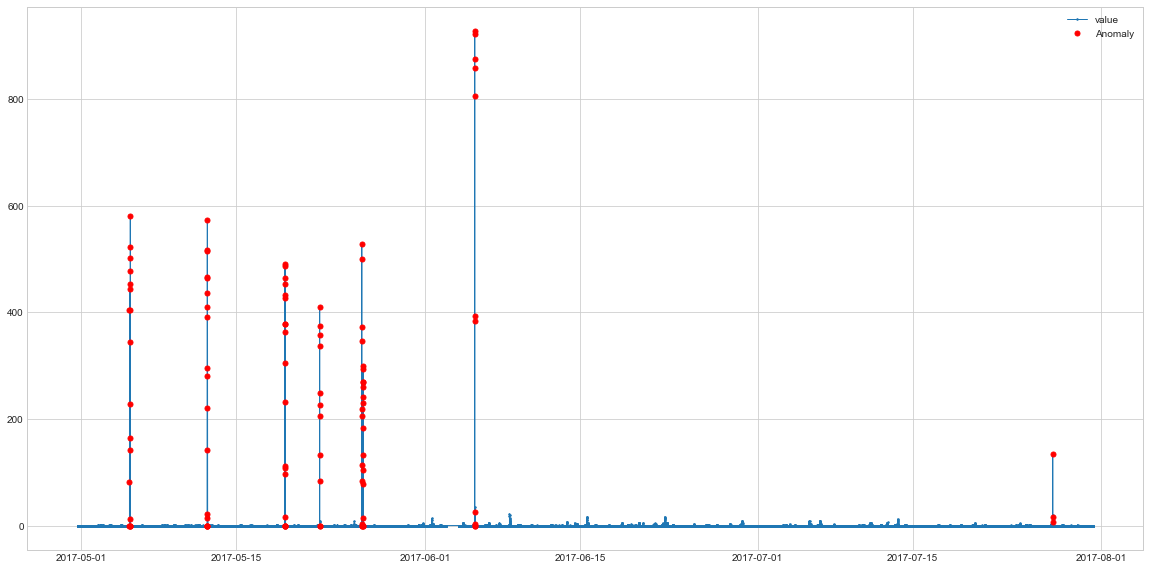

In [625]:
#Isolation Forest Best
best_if = performance_df['Isolation Forest'].sort_values().index[-1]
best_data = train.loc[train['KPI ID'] == best_if, :]
best_data.timestamp = best_data.timestamp.apply(lambda x: datetime.fromtimestamp(x))
best_data.index = best_data.timestamp
c = contamination_dict[best_if]
anomalies = detector.isolation_f(best_data.value, c)
print('Ground Truth')
plot(best_data.value, anomaly=best_data.label, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Predicted


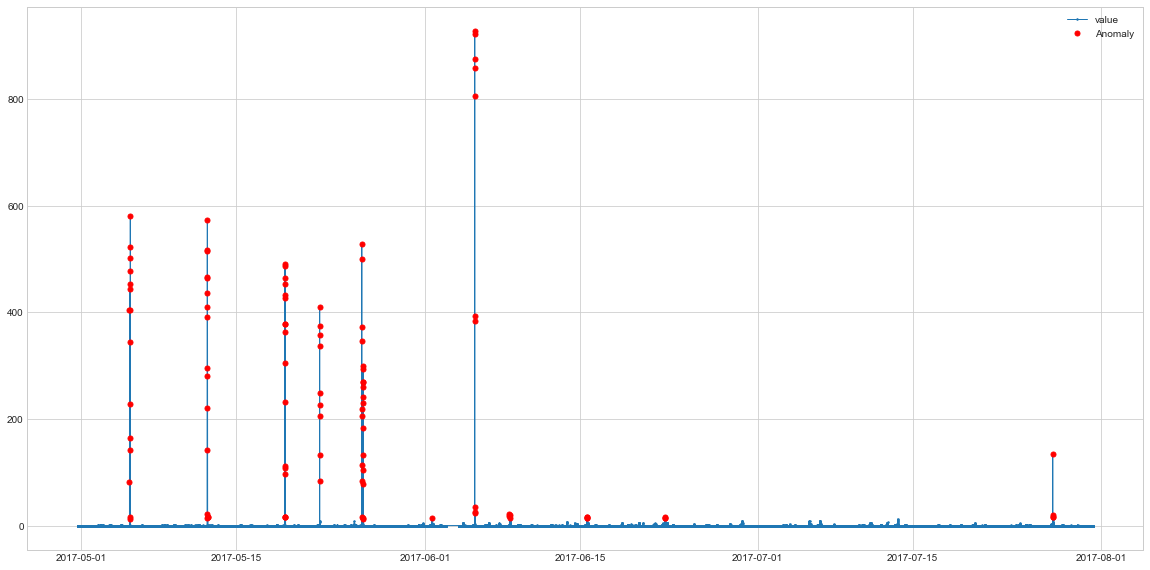

In [626]:
print('Predicted')
plot(best_data.value, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Here isolation forest does quite well and it's not surprising. This case has no seasonality and the outliers are clearly visible.There's no context to understand, so 1 feature isolation forest is ineed the best choice. Let's see where it fails to perform well.

C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Ground Truth


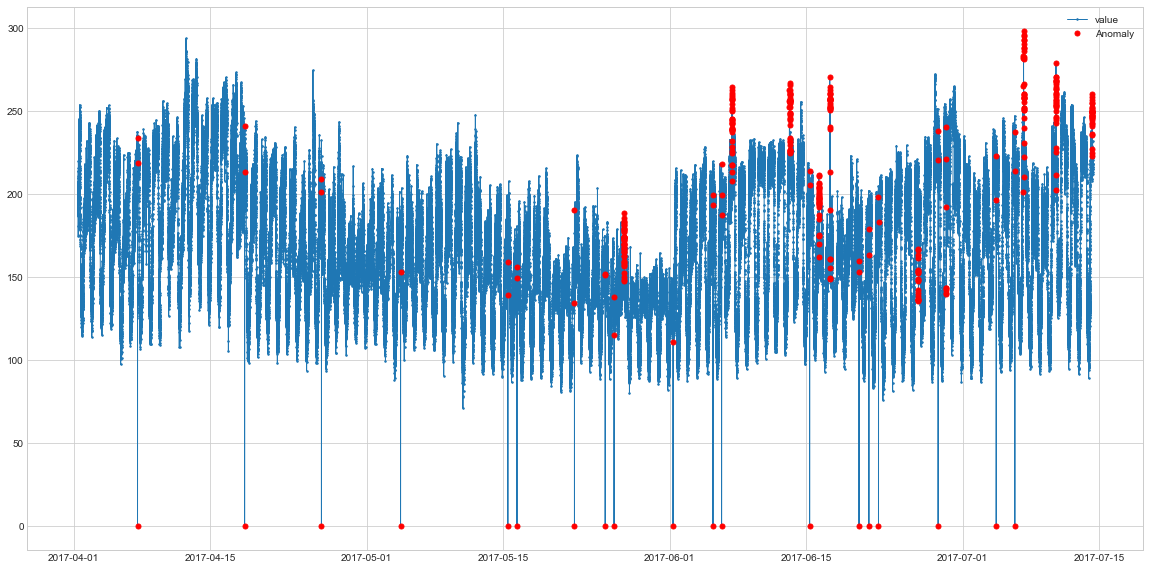

In [627]:
#Isolation Forest Worst
worst_if = performance_df['Isolation Forest'].sort_values().index[0]
worst_data = train.loc[train['KPI ID'] == worst_if, :]
worst_data.timestamp = worst_data.timestamp.apply(lambda x: datetime.fromtimestamp(x))
worst_data.index = worst_data.timestamp
c = contamination_dict[worst_if]
anomalies = detector.isolation_f(worst_data.value, c)
print('Ground Truth')
plot(worst_data.value, anomaly=worst_data.label, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Predicted


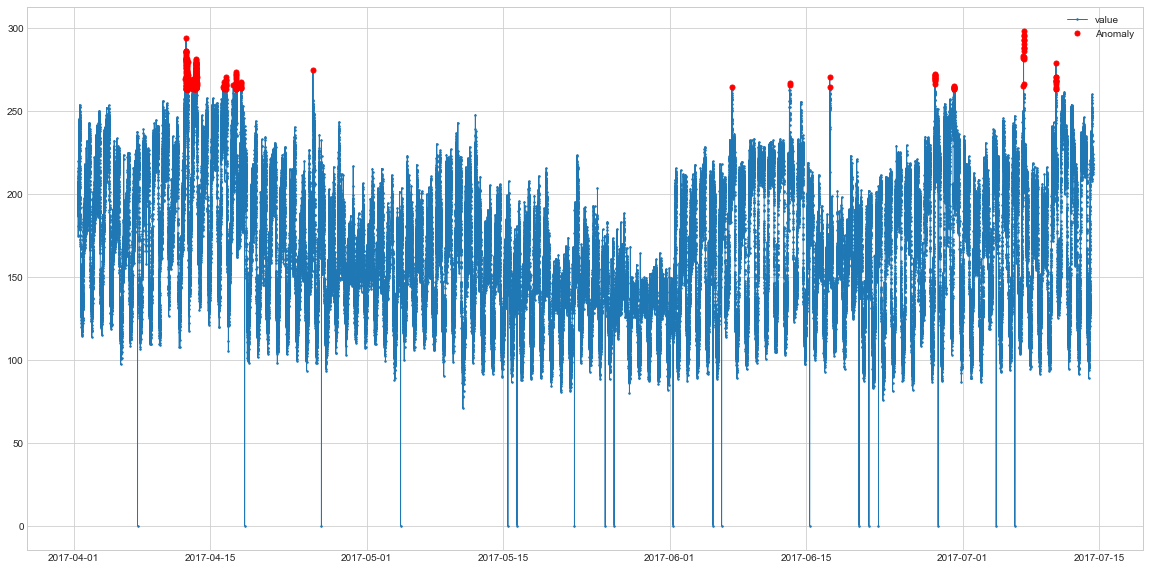

In [628]:
print('Predicted')
plot(worst_data.value, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

In the contrast to the previous series, this one has clear seasonality and level shifts in it. Isolation forest fails to detect most fo the outliers, hence it should not be used in the case of complex time series (at least without any adjustments)

### Seasonal Model Exploration

Ground Truth


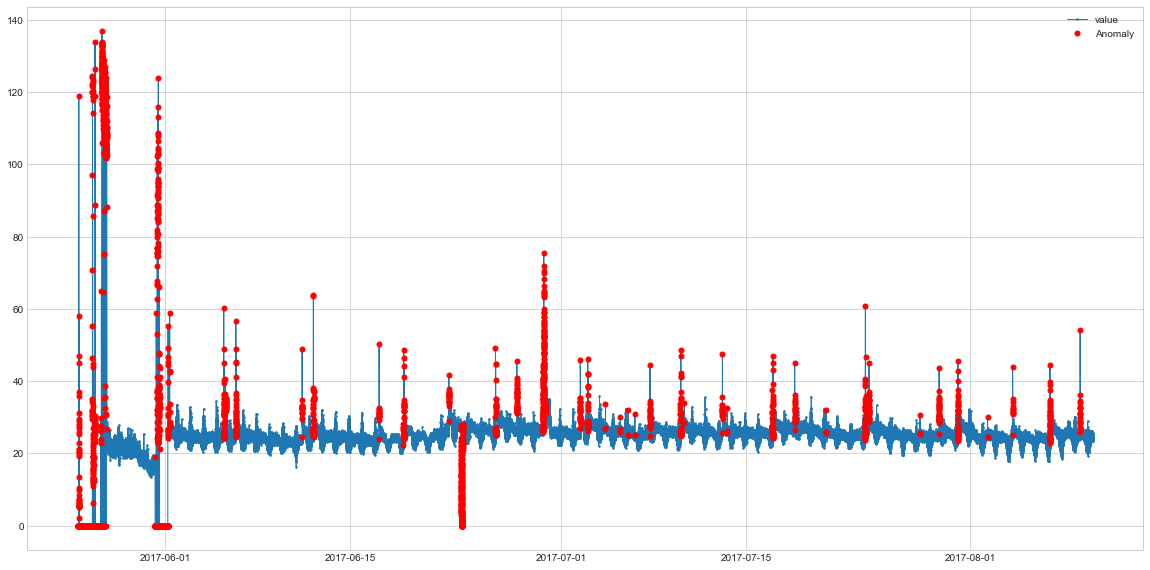

In [633]:
#Seasonal Best
best_seasonal = performance_df['Seasonal Model'].sort_values().index[-1]
best_data = train.loc[train['KPI ID'] == best_seasonal, :]
best_data.timestamp = best_data.timestamp.apply(lambda x: datetime.fromtimestamp(x))
best_data.index = best_data.timestamp
c = contamination_dict[best_seasonal]
anomalies = detector.seasonal(best_data.value.resample(pd.infer_freq(best_data.index[:5])).sum())
print('Ground Truth')
plot(best_data.value, anomaly=best_data.label, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Predicted


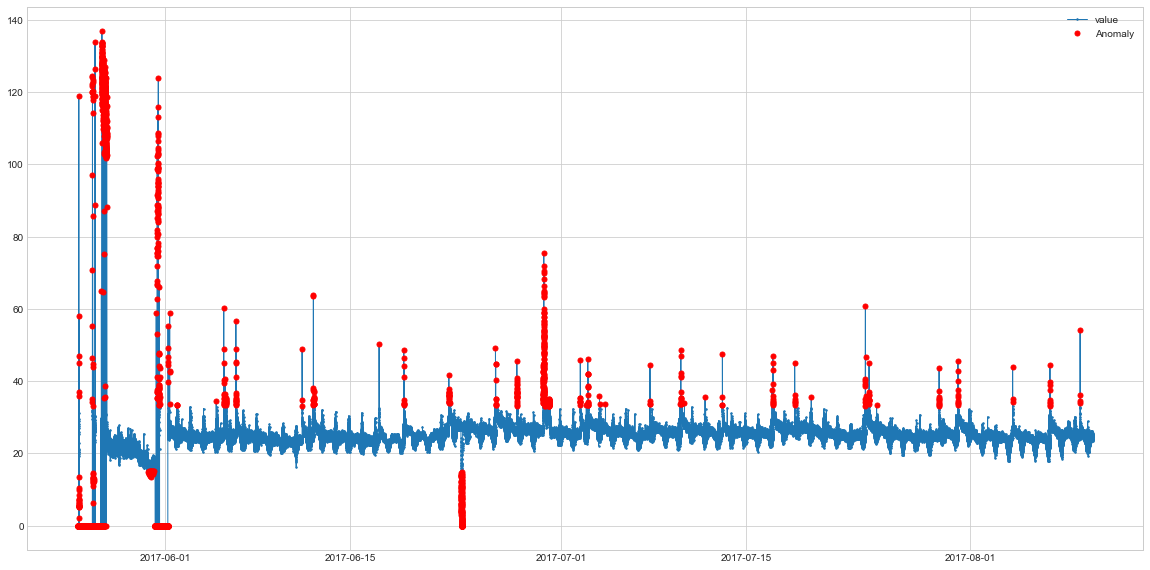

In [640]:
print('Predicted')
plot(best_data.value, anomaly=anomalies[best_data.index], ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Here the data clearly has seasonal patterns, so the seasonal model is the best choice here. Setting simple thresholds or using rolling averages wouldn't work here, so detecting seasonality in these kinds of data is crucial. Now, let's see where seasonal model won't help us in finding the anomalies. 

C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Ground Truth


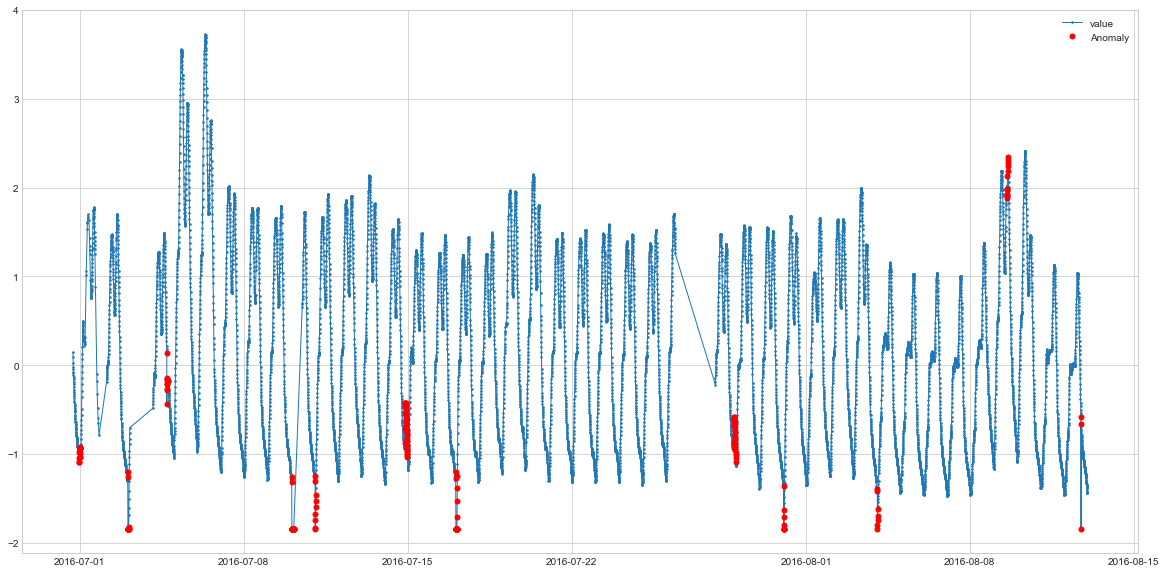

In [641]:
#Seasoanl Worst
worst_seasonal = performance_df['Seasonal Model'].sort_values().index[0]
worst_data = train.loc[train['KPI ID'] == worst_seasonal, :]
worst_data.timestamp = worst_data.timestamp.apply(lambda x: datetime.fromtimestamp(x))
worst_data.index = worst_data.timestamp
c = contamination_dict[worst_seasonal]
anomalies = detector.seasonal(worst_data.value.resample(pd.infer_freq(worst_data.index[:5])).sum())
print('Ground Truth')
plot(worst_data.value, anomaly=worst_data.label, ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

Predicted


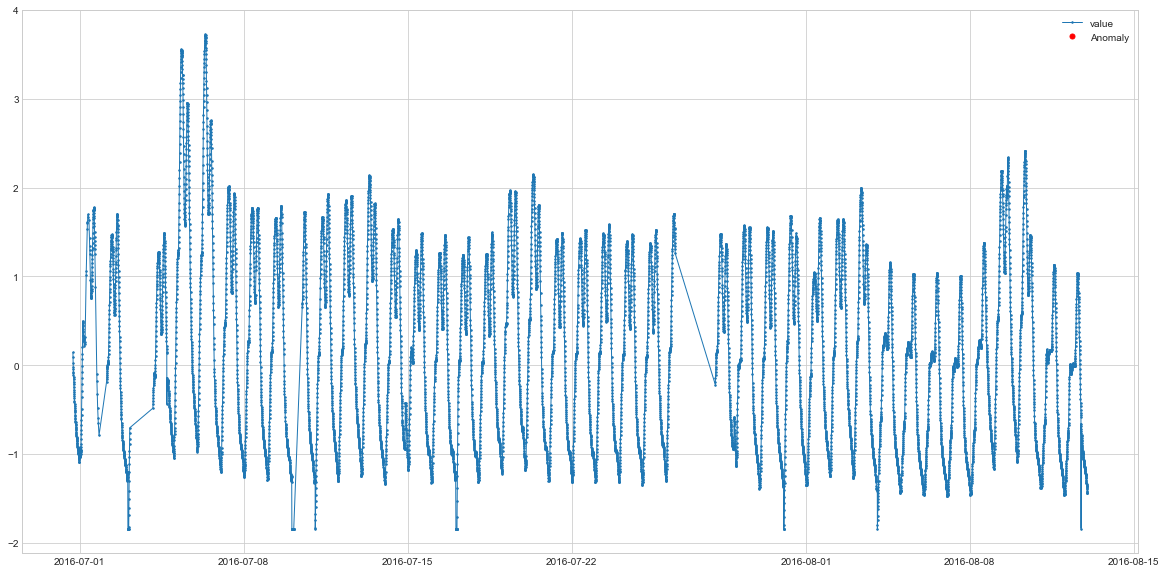

In [642]:
print('Predicted')
plot(worst_data.value, anomaly=anomalies[worst_data.index], ts_linewidth=1, ts_markersize=3, anomaly_color='red', figsize=(20,10), anomaly_tag="marker", anomaly_markersize=5)

This type of data highly irregular as it clearly has some missing data points. Also the seasonal pattern changes and is hard to establish to begin with. It's not surprising as simple time series decomposition failed as this type of data requires more sophisticated models.

Overall, it is clear that you need to know your data before deciding on the anomaly detection algorithm. Further steps could involve adding contextual data to HDBSCAN and Isolation Forest since they can take basically any number of variables.